In [47]:
# Importing required packages and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import spearmanr

import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import IFrame
import webbrowser

In [48]:
# Overview and grouping of the datacolumns for loop later on
numerical_columns = ['Price','price_per_sqm','price_per_sqm_land','Living_area','landSurface','gardenSurface', 'terraceSurface','Number_of_facades','Number_of_bedrooms']
categorical_columns = ['Subtype','Kitchen_type','State_of_building','epc','Postal_code','Province', 'Assigned_City']
binary_columns = ['Swimming_Pool','Open_fire','Furnished', 'Has_Assigned_City'] # 'hasTerrace', not reliably maintained so leaving it out of analyzing/visualization

**Generating a pandas dataframe from the source .pkl file**

In [49]:
# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load .pkl file and generate pandas dataframe
input_pkl = r'..\data\clean\after_step_3b_outliers_cat.pkl' # Fill your path to file
df_1 = pd.read_pickle(input_pkl)

df_1_shape = df_1.shape # Pass the shape of the dataframe to a variable for summary at end of the outlier detection and removal part
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4180 entries, 0 to 5923
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         4180 non-null   Int64   
 1   locality_name              4180 non-null   category
 2   Postal_code                4180 non-null   object  
 3   Price                      4180 non-null   Int64   
 4   Subtype                    4180 non-null   object  
 5   Number_of_bedrooms         4180 non-null   Int64   
 6   Living_area                4180 non-null   Int64   
 7   street                     4180 non-null   category
 8   number                     4165 non-null   category
 9   latitude                   4180 non-null   float64 
 10  longitude                  4180 non-null   float64 
 11  Open_fire                  4180 non-null   bool    
 12  Swimming_Pool              4180 non-null   bool    
 13  hasTerrace                 2813 non-nu

**Approach**

*Numerical data:*
1. Scatter plots

2. Determine if two numerical datasets have a linear correlation, via Pearson coefficient:
- 0.0 to 0.3: Weak
- 0.3 to 0.7: Moderate
- 0.7 to 1.0: Strong
--> generate matrix and heat map for visualization

3. If non-linear: Spearman’s Correlation for non-linear correlation of data (non-parametric measure of monotonic relationships) --> values from -1 to 1:
- 0.0 to 0.3 (or 0.0 to -0.3): Weak correlation
- 0.3 to 0.7 (or -0.3 to -0.7): Moderate correlation
- 0.7 to 1.0 (or -0.7 to -1.0): Strong correlation
--> generate matrix and heat map for visualization

*Categorical data:*
1. Scatter plots
2. Spearman’s Correlation for non-linear correlation of data (non-parametric measure of monotonic relationships)
--> generate matrix and heat map for visualization

*Boolean data:*
1. Scatter plots
2. Determine linear relationships between a binary and numerical dataset, via Point-Biserial Correlation:
- 0.0 to 0.3 (or 0.0 to -0.3): Weak correlation
- 0.3 to 0.7 (or -0.3 to -0.7): Moderate correlation
- 0.7 to 1.0 (or -0.7 to -1.0): Strong correlation
--> generate matrix and heat map for visualization

3. If non-linear, but you suspect monotonic relationship: Spearman’s Rank Correlation
--> generate matrix and heat map for visualization

*When to Use Spearman’s Rank Correlation:*
-Non-linear relationships: When you suspect the relationship between variables is monotonic but not linear.
-Ordinal data: When your data is not continuous or normally distributed (e.g., ranks, ordered categories).
-Robust to outliers: Spearman’s correlation is less sensitive to outliers because it uses rank values rather than actual data values.

**All numerical data - display pairplots and check linearity via Pearson .corr() method**

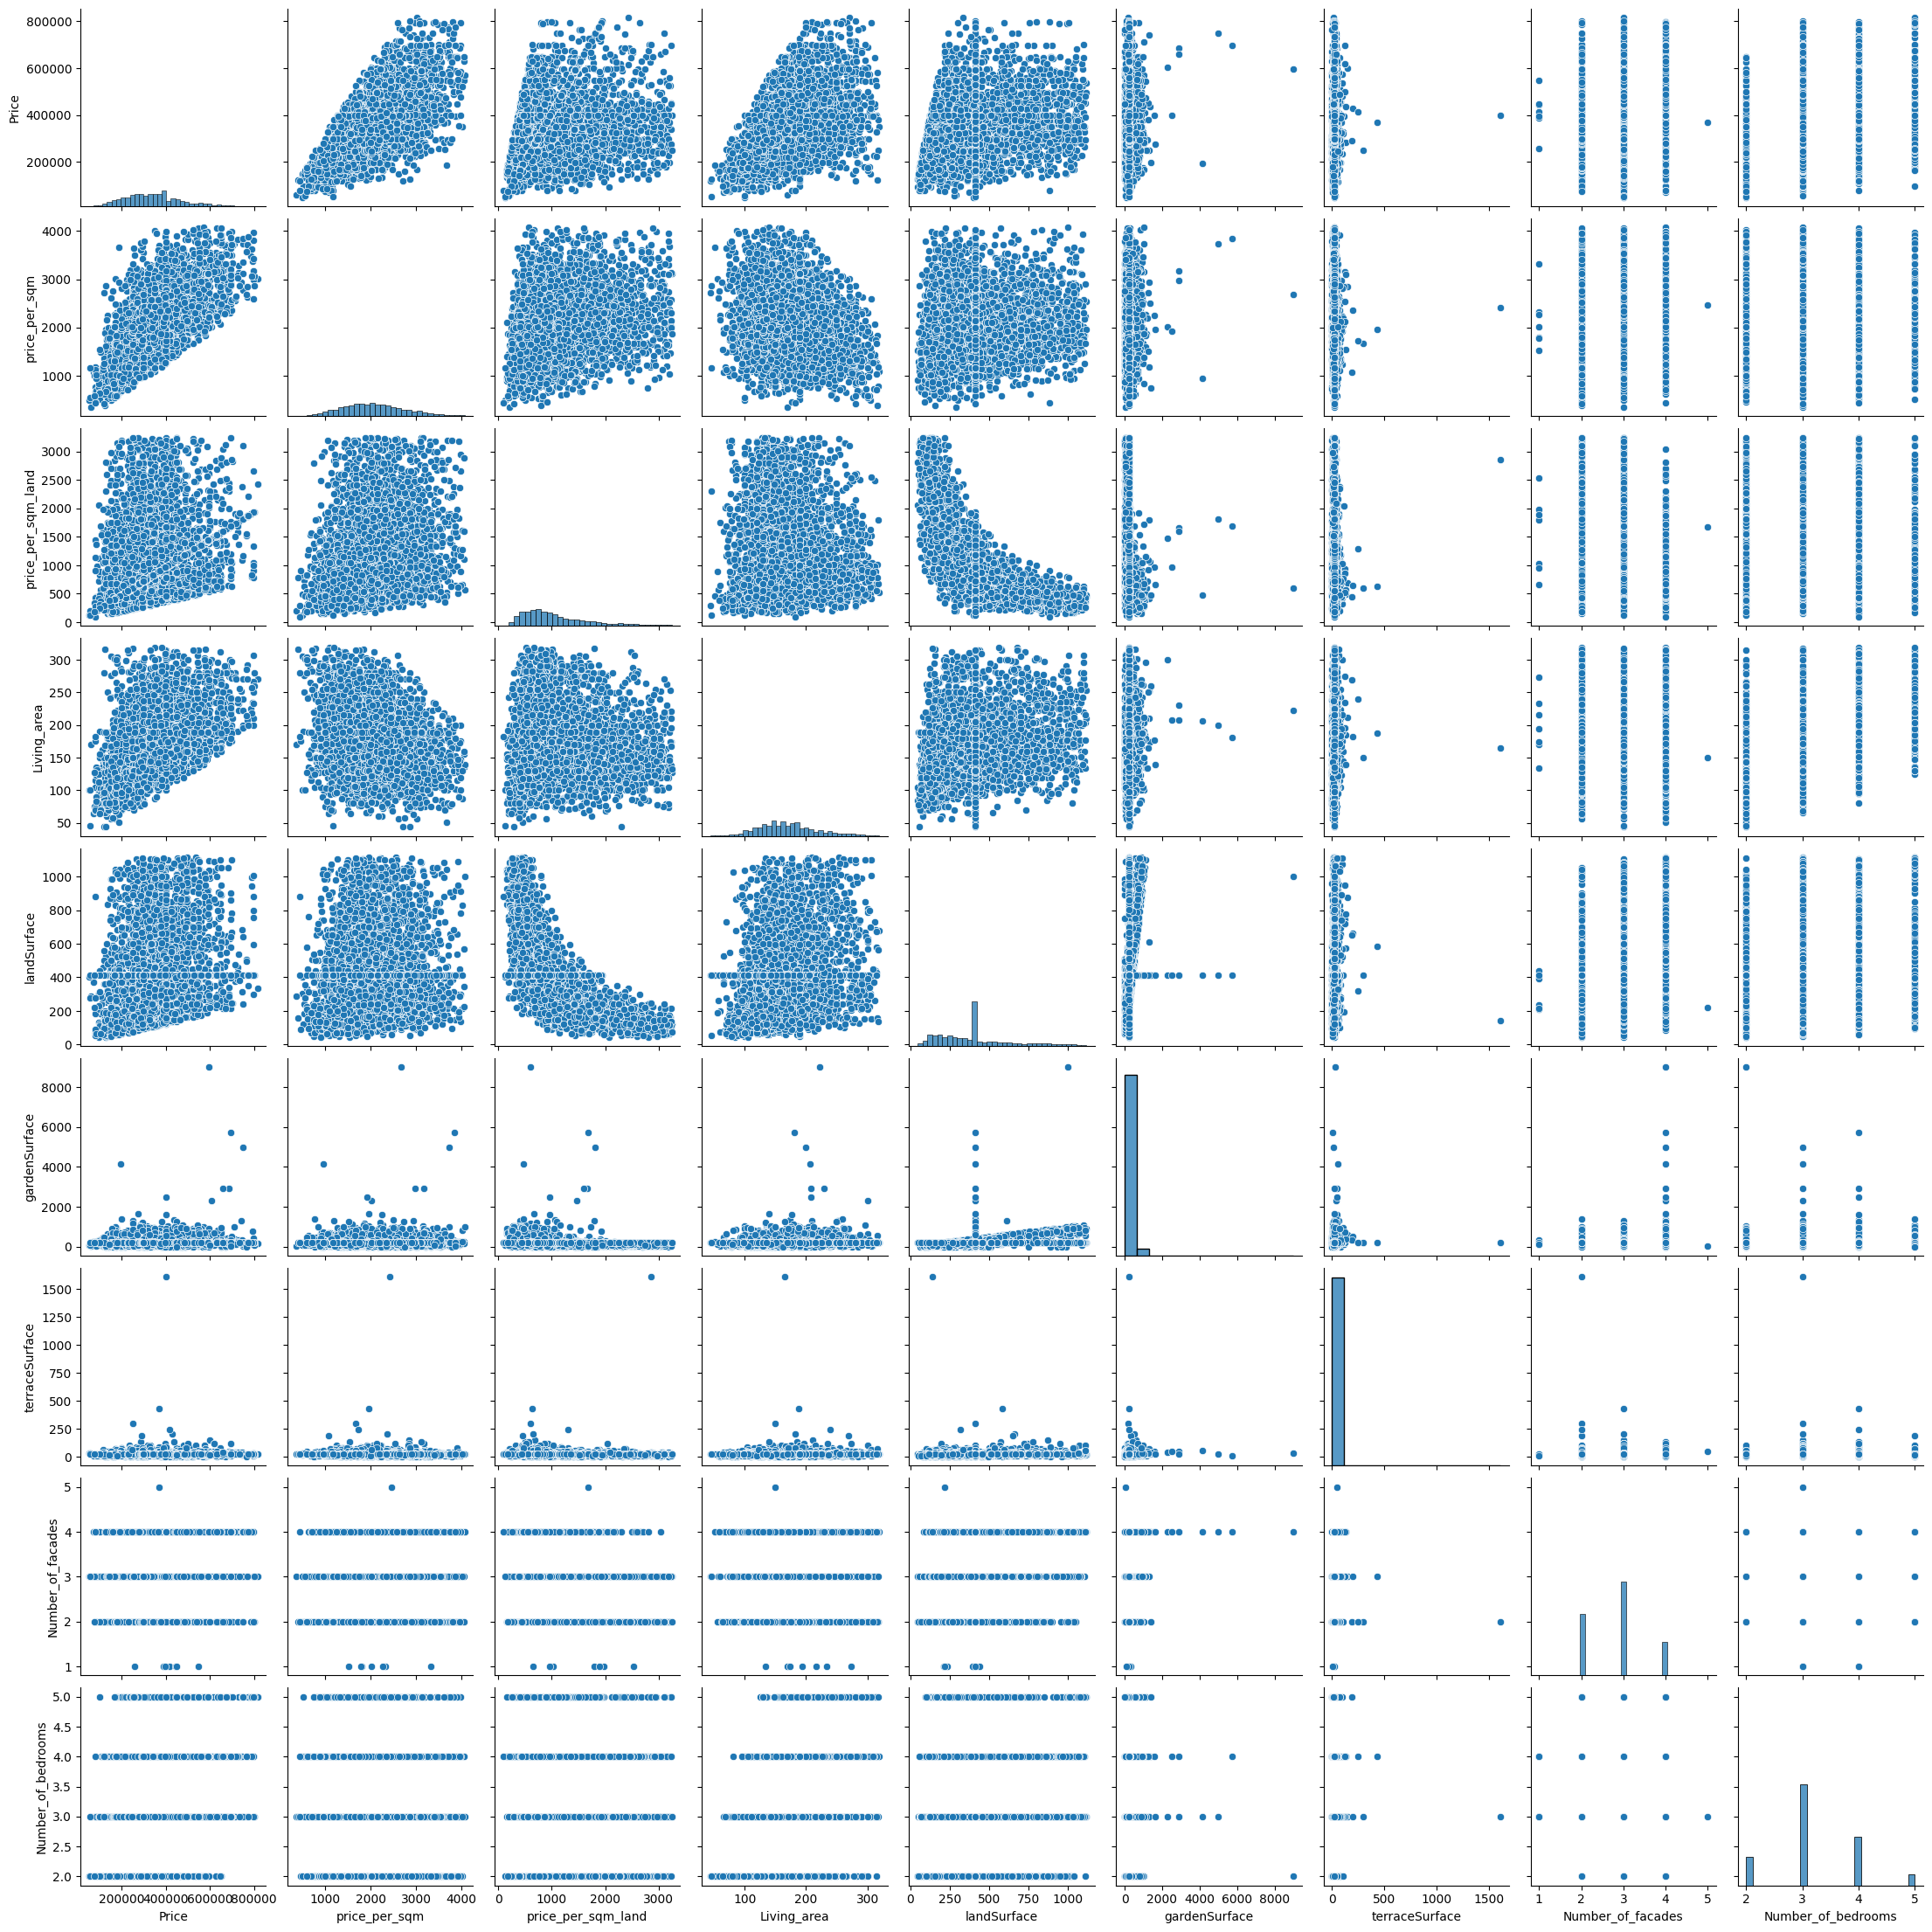

Pearson correlation coefficients:
                       Price  price_per_sqm  price_per_sqm_land  Living_area  \
Price               1.000000       0.688861            0.227726     0.490667   
price_per_sqm       0.688861       1.000000            0.258011    -0.246035   
price_per_sqm_land  0.227726       0.258011            1.000000    -0.002283   
Living_area         0.490667      -0.246035           -0.002283     1.000000   
landSurface         0.293730       0.125853           -0.687935     0.244306   
gardenSurface       0.106576       0.052885           -0.203533     0.069396   
terraceSurface      0.033796       0.004252           -0.007085     0.037572   
Number_of_facades   0.210215       0.151100           -0.327130     0.104069   
Number_of_bedrooms  0.307724      -0.045918            0.055506     0.475353   

                    landSurface  gardenSurface  terraceSurface  \
Price                  0.293730       0.106576        0.033796   
price_per_sqm          0.125853  

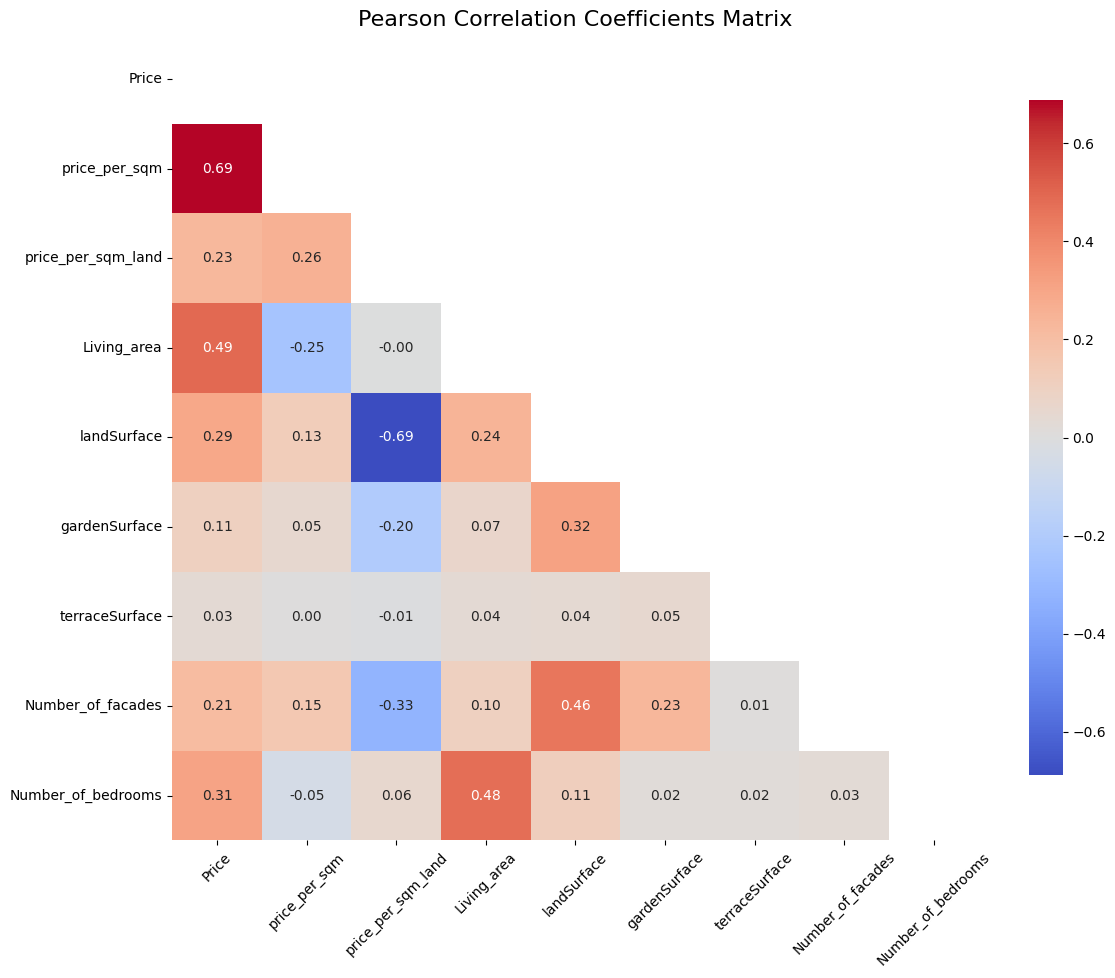

In [50]:
# Select numerical variables
#numerical_columns = df_1.select_dtypes(include=['Int64', 'float64']).columns.tolist()

# Step 1: Visualize the relationship using scatter plots
sns.pairplot(df_1[numerical_columns])
plt.show()

# Step 2: Calculate Pearson correlation coefficient only for numerical variables
pearson_correlation = df_1[numerical_columns].corr(method='pearson')

# Display the Pearson correlation coefficients table
print("Pearson correlation coefficients:")
print(pearson_correlation)

# Step 3: Create the heatmap matrix
# # Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(pearson_correlation, dtype=bool))

# # Set up the plot
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_correlation, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, mask=mask)

# Add title
plt.title('Pearson Correlation Coefficients Matrix', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=0)   # Y-axis labels horizontal
plt.tight_layout()       # Automatically adjust layout
plt.show()

**Display pairplots and check linearity of binary data versus numerical data via Point-Biserial .corr() method**


                      Price price_per_sqm price_per_sqm_land Living_area  \
Swimming_Pool      0.110378      0.061659          -0.026934    0.067304   
Open_fire          0.076683      0.014446          -0.026958    0.080758   
Furnished          0.010761      0.048547          -0.004896   -0.032182   
Has_Assigned_City  0.115413      0.149146            0.23804   -0.025853   

                  landSurface gardenSurface terraceSurface Number_of_facades  \
Swimming_Pool        0.093136      0.044545       0.024327          0.073654   
Open_fire            0.077052      0.066541       0.008455          0.069965   
Furnished            0.016474       0.01362       0.013181          0.027486   
Has_Assigned_City   -0.154017     -0.092139       0.001932         -0.171541   

                  Number_of_bedrooms  
Swimming_Pool               0.037635  
Open_fire                   0.033092  
Furnished                  -0.011491  
Has_Assigned_City           0.027209  


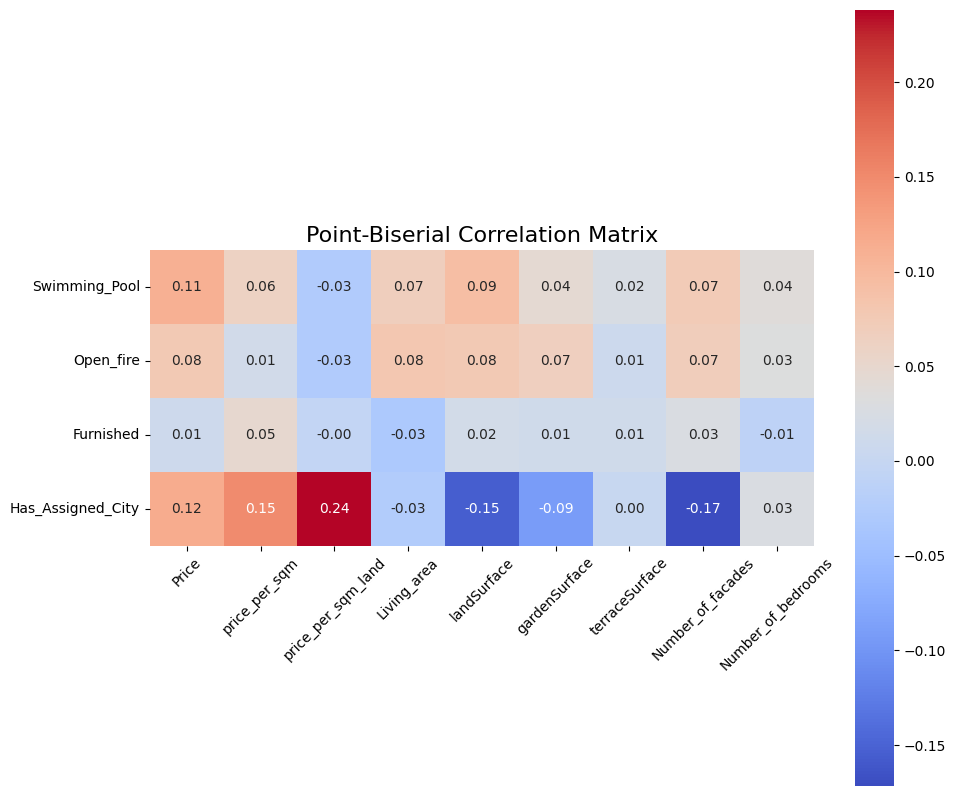

In [51]:
# Convert boolean columns to 0/1 for calculation
df_1[binary_columns] = df_1[binary_columns].astype(int)

# Create an empty DataFrame to store the point-biserial correlations
correlation_matrix = pd.DataFrame(index=binary_columns, columns=numerical_columns)

# Calculate point-biserial correlation for each binary vs numerical pair
for binary_col in binary_columns:
    for numerical_col in numerical_columns:
        corr, _ = pointbiserialr(df_1[binary_col], df_1[numerical_col])
        correlation_matrix.loc[binary_col, numerical_col] = corr

# Display the correlation matrix
print(correlation_matrix)

# Convert the correlation matrix to numeric values for visualization
correlation_matrix = correlation_matrix.astype(float)

# Set up the plot
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title
plt.title('Point-Biserial Correlation Matrix', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=0)   # Y-axis labels horizontal
plt.tight_layout()       # Automatically adjust layout
plt.show()


**Checking correlation of encoded categorical (= ordinal data) to numerical data, as well as correlations that were non-linear in Pearson and point-biserial tests, via Spearman method**

Spearman's Correlation Matrix:
                        Price  price_per_sqm  price_per_sqm_land  Living_area  \
Price               1.000000       0.692438            0.289204     0.490746   
price_per_sqm       0.692438       1.000000            0.298032    -0.228418   
price_per_sqm_land  0.289204       0.298032            1.000000     0.032186   
Living_area         0.490746      -0.228418            0.032186     1.000000   
landSurface         0.312013       0.132083           -0.783575     0.266729   
gardenSurface       0.063016       0.006446           -0.398835     0.083053   
terraceSurface      0.070264      -0.003084           -0.090262     0.101022   
Number_of_facades   0.205601       0.151989           -0.321214     0.109353   
Number_of_bedrooms  0.302215      -0.041702            0.069310     0.475248   
Subtype                  NaN            NaN                 NaN          NaN   
Kitchen_type        0.018608       0.032428            0.015062    -0.019845   
State_of

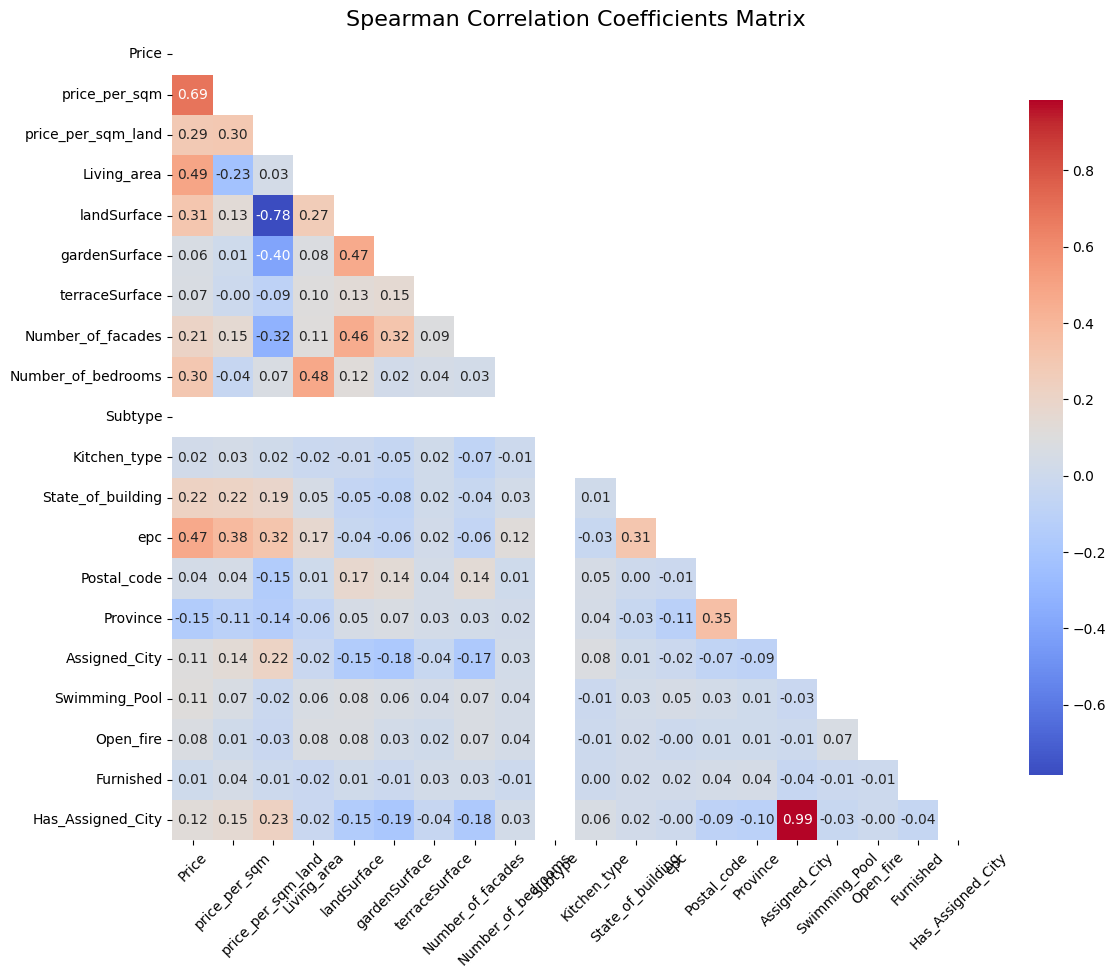

In [52]:
# Step 1: select categorical and binary columns
non_numerical_columns = categorical_columns + binary_columns
all_data_columns = numerical_columns + non_numerical_columns

# Step2: Encode the non-numerical columns to numerical values using pd.factorize and keep the other data columns intact in the dataframe
df_1_encoded = df_1[non_numerical_columns].apply(lambda x: pd.factorize(x)[0]) #code to encode an keep only the altered columns
df_1[non_numerical_columns] = df_1[non_numerical_columns].apply(lambda x: pd.factorize(x)[0]) # code to keep the other data columns intact in the dataframe

# Step 3: Calculate Spearman's correlation coefficient --> choose
#spearman_correlation_matrix = df_1_encoded.corr(method='spearman')
spearman_correlation_matrix = df_1[all_data_columns].corr(method='spearman')

# Step 4: Display the coefficients table
print("Spearman's Correlation Matrix:\n", spearman_correlation_matrix)

# Step 5: Create a heat map matrix
# # Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(spearman_correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, mask=mask)

# Add title
plt.title('Spearman Correlation Coefficients Matrix', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=0)   # Y-axis labels horizontal
plt.tight_layout()       # Automatically adjust layout
plt.show()

Spearman's correlation for price_per_sqm_land versus Price
Spearman's correlation: 0.2892044198817184
P-value: 2.4323250102729595e-81
Spearman's Correlation Matrix:
                        Price  price_per_sqm  price_per_sqm_land  Living_area  \
Price               1.000000       0.692438            0.289204     0.490746   
price_per_sqm       0.692438       1.000000            0.298032    -0.228418   
price_per_sqm_land  0.289204       0.298032            1.000000     0.032186   
Living_area         0.490746      -0.228418            0.032186     1.000000   
landSurface         0.312013       0.132083           -0.783575     0.266729   
gardenSurface       0.063016       0.006446           -0.398835     0.083053   
terraceSurface      0.070264      -0.003084           -0.090262     0.101022   
Number_of_facades   0.205601       0.151989           -0.321214     0.109353   
Number_of_bedrooms  0.302215      -0.041702            0.069310     0.475248   

                    landSurface  

<Axes: >

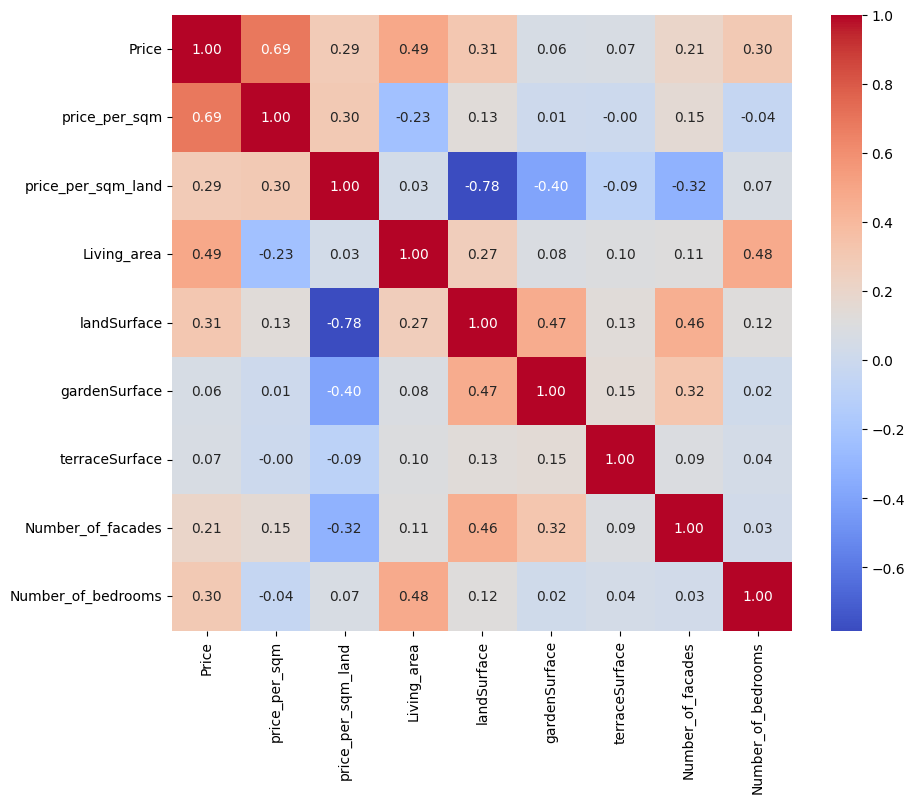

In [53]:
# Calculate Spearman's correlation

corr, p_value = spearmanr(df_1[col], df_1['Price'])

print(f"Spearman's correlation for {col} versus Price")
print(f"Spearman's correlation: {corr}")
print(f"P-value: {p_value}")

# Step 3: Calculate correlations
# Create the Spearman's Rank Correlation matrix
spearman_corr_matrix = df_1[numerical_columns].corr(method='spearman')

# Display the matrix
print("Spearman's Correlation Matrix:\n", spearman_corr_matrix)

# Step 4: Create a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

**Correlation scatter plot to use for 'just 2 datasets': lmplot**

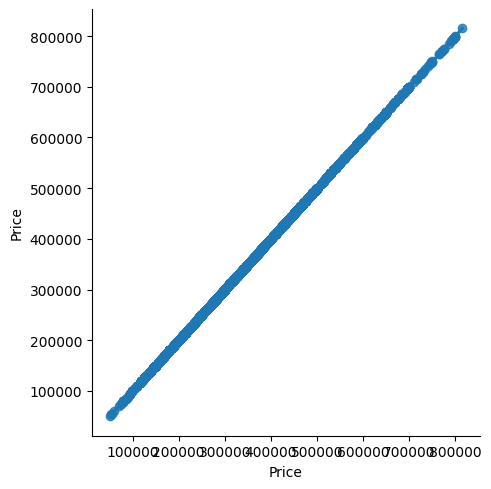

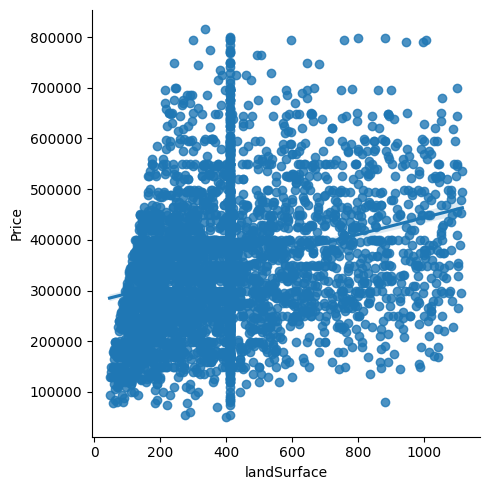

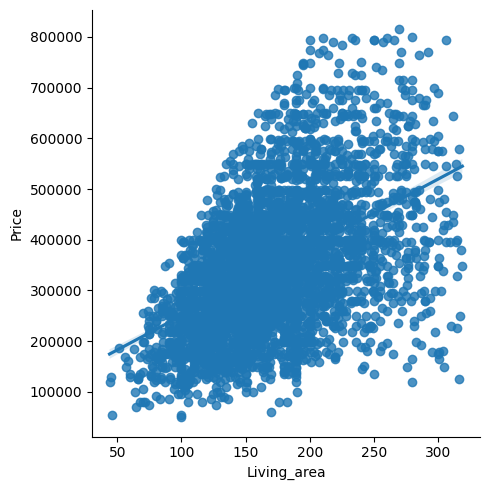

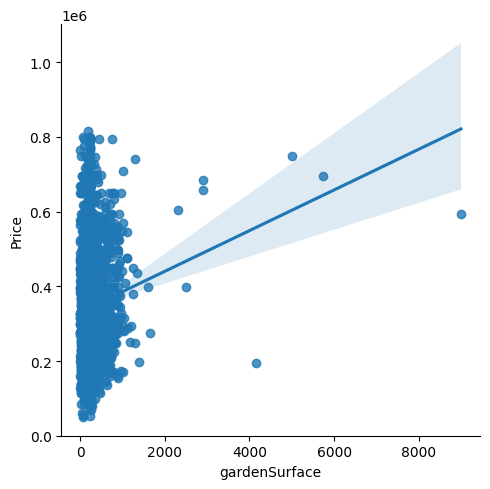

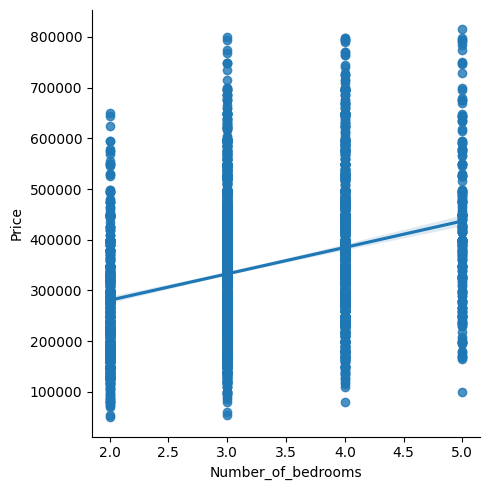

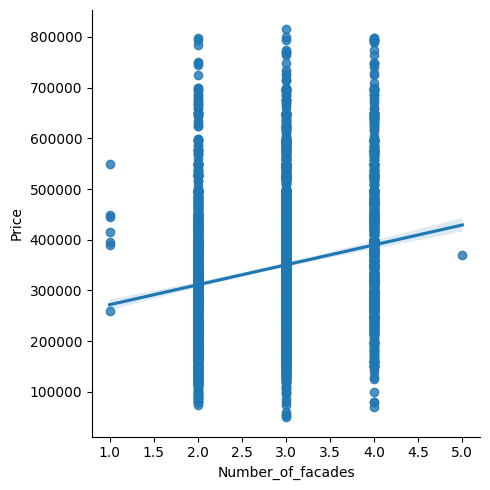

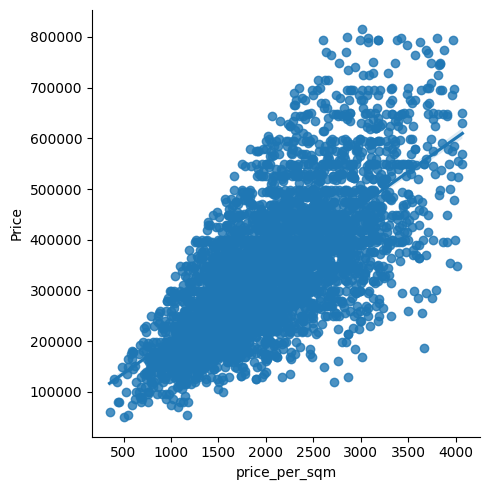

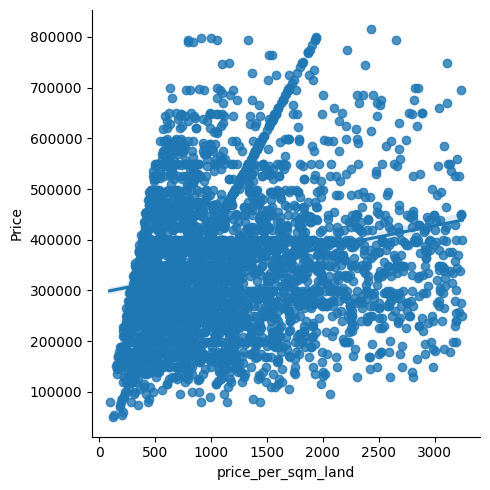

In [54]:
cols_to_plot = ['Price','landSurface', 'Living_area','gardenSurface', 'Number_of_bedrooms', 'Number_of_facades','price_per_sqm', 'price_per_sqm_land']
for col in cols_to_plot:
    sns.lmplot(data=df_1, x=col, y="Price") #col="time", hue="smoker"


**Saving data to a new .csv file and a .pkl file**

In [55]:
# Save data to new csv file

output_csv = r'..\data\clean\after_step_4_correlation.csv'  # Fill your path to file
df_1.to_csv(output_csv, index=False)


# Save data to new pkl file

import pickle
output_pkl = r'..\data\clean\after_step_4_correlation.pkl' # Fill your path to file
with open(output_pkl, 'wb') as f:
    pickle.dump(df_1, f)
